In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [2]:
df = pd.read_csv('ner_dataset.csv',encoding = 'ISO-8859-1')
df = df[:10000]
df.head(10)

Sentence #           Word  POS    Tag
0  Sentence: 1      Thousands  NNS      O
1          NaN             of   IN      O
2          NaN  demonstrators  NNS      O
3          NaN           have  VBP      O
4          NaN        marched  VBN      O
5          NaN        through   IN      O
6          NaN         London  NNP  B-geo
7          NaN             to   TO      O
8          NaN        protest   VB      O
9          NaN            the   DT      O

In [3]:
df.isna().sum()

Sentence #    9543
Word             0
POS              0
Tag              0
dtype: int64

In [4]:
df  = df.fillna(method ='ffill')

In [5]:
df.head()

Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O

<AxesSubplot:>

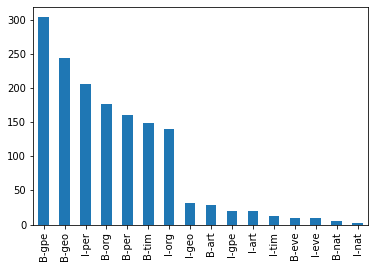

In [6]:
df[df.Tag!='O'].Tag.value_counts().plot(kind='bar')

In [7]:
classes = df.Tag.unique()

In [8]:
classes = classes.tolist()
classes

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

In [9]:
class SentenceGetter():
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                           s['POS'].values.tolist(), 
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None
getter = SentenceGetter(df)
sentences = getter.sentences

In [10]:
sentences

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

In [11]:
len(sentences)

457

In [12]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

In [13]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [14]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

In [15]:
sent2labels(sentences[1])

['B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-tim',
 'O',
 'O',
 'O',
 'B-org',
 'O',
 'O',
 'O',
 'O',
 'O']

In [16]:
sent2features(sentences[1])

[{'bias': 1.0,
  'word.lower()': 'iranian',
  'word[-3:]': 'ian',
  'word[-2:]': 'an',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'postag': 'JJ',
  'postag[:2]': 'JJ',
  'BOS': True,
  '+1:word.lower()': 'officials',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'NNS',
  '+1:postag[:2]': 'NN'},
 {'bias': 1.0,
  'word.lower()': 'officials',
  'word[-3:]': 'als',
  'word[-2:]': 'ls',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'NNS',
  'postag[:2]': 'NN',
  '-1:word.lower()': 'iranian',
  '-1:word.istitle()': True,
  '-1:word.isupper()': False,
  '-1:postag': 'JJ',
  '-1:postag[:2]': 'JJ',
  '+1:word.lower()': 'say',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'VBP',
  '+1:postag[:2]': 'VB'},
 {'bias': 1.0,
  'word.lower()': 'say',
  'word[-3:]': 'say',
  'word[-2:]': 'ay',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit

In [17]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [18]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',### l2sgd
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True)
# L*L
crf.fit(X_train, y_train)

c:\users\king\anaconda3\envs\keras\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [19]:
new_classes = classes[1:]#classes.copy()
# new_classes.pop()
new_classes

['B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

In [20]:
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels = new_classes))

              precision    recall  f1-score   support

       B-geo       0.79      0.68      0.73        77
       B-gpe       0.75      0.88      0.81        91
       B-per       0.85      0.92      0.88        61
       I-geo       0.75      0.38      0.50        16
       B-org       0.77      0.68      0.72        53
       I-org       0.74      0.70      0.72        50
       B-tim       0.95      0.89      0.92        45
       B-art       0.50      0.40      0.44         5
       I-art       0.00      0.00      0.00         4
       I-per       0.87      0.97      0.92        75
       I-gpe       0.67      0.57      0.62         7
       I-tim       0.33      1.00      0.50         1
       B-nat       0.00      0.00      0.00         2
       B-eve       0.00      0.00      0.00         2
       I-eve       0.00      0.00      0.00         1
       I-nat       0.00      0.00      0.00         2

   micro avg       0.80      0.78      0.79       492
   macro avg       0.50   

c:\users\king\anaconda3\envs\keras\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
c:\users\king\anaconda3\envs\keras\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
metrics.flat_f1_score(y_test, y_pred, average='weighted',labels = new_classes)

0.7781509202352701